# Agent interaction analysis
## Step by step data extraction

In [1]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt
from egg.zoo.pop.scripts.analysis_tools.analysis import interaction_to_dataframe, name_to_idx, extract_name
import seaborn as sns
# used in a later part of the script :
# import numpy as np
import scipy

In [60]:
# Path to your interaction files
base_path = Path("/Users/u203445/Documents/projects/EGG/interactions")

# 1st file is a full population playing the Lazaridou communication game
# 2nd file is the full population trained normally but tested on a game where both target and distractor go through augmentations
# 3rd file is a vgg-vgg pair with augmentations only on the distractors (target is the same as it was during training)
# 4th file is a vgg-vgg pair with augmentations on target and distractors
# interaction_files = ["cont_interactions_2","cont_interactions_aug","vgg_distaugment_interactions","vgg_allaugment_interactions", "noisy_channel", "separate_aug"]
# interaction_files = [
    # "./noisy_channel_0.1", 
#     "./noisy_channel_0.5", 
# ]
models = ['vgg11','vit','resnet152', 'inception']
interaction_files = [f"gaussian_blur['{model1}']['{model2}']" for model1 in models for model2 in models]
interaction_files.append("fullpop")
print(interaction_files)
inters = [torch.load(base_path / file) for file in interaction_files]
df_inters = [interaction_to_dataframe(inter) for inter in inters] # <-- put interactions into dataframes which are easy to handle 
# print("available information in dataframe : \n", df_inters[0].columns)



["gaussian_blur['vgg11']['vgg11']", "gaussian_blur['vgg11']['vit']", "gaussian_blur['vgg11']['resnet152']", "gaussian_blur['vgg11']['inception']", "gaussian_blur['vgg11']['swin']", "gaussian_blur['vgg11']['dino']", "gaussian_blur['vit']['vgg11']", "gaussian_blur['vit']['vit']", "gaussian_blur['vit']['resnet152']", "gaussian_blur['vit']['inception']", "gaussian_blur['vit']['swin']", "gaussian_blur['vit']['dino']", "gaussian_blur['resnet152']['vgg11']", "gaussian_blur['resnet152']['vit']", "gaussian_blur['resnet152']['resnet152']", "gaussian_blur['resnet152']['inception']", "gaussian_blur['resnet152']['swin']", "gaussian_blur['resnet152']['dino']", "gaussian_blur['inception']['vgg11']", "gaussian_blur['inception']['vit']", "gaussian_blur['inception']['resnet152']", "gaussian_blur['inception']['inception']", "gaussian_blur['inception']['swin']", "gaussian_blur['inception']['dino']", "gaussian_blur['swin']['vgg11']", "gaussian_blur['swin']['vit']", "gaussian_blur['swin']['resnet152']", "ga

FileNotFoundError: [Errno 2] No such file or directory: "\\Users\\u203445\\Documents\\projects\\EGG\\interactions\\gaussian_blur['vgg11']['swin']"

In [3]:
# if we want to work from a csv file instead
# for i,df_inter in enumerate(df_inters):
#     print(df_inter.to_csv(base_path / (interaction_files[i] + ".csv")))

### A few numbers to explain the data

In [4]:
indexed_printing = True # UI : if set to false, file names are used instead of indices

# check performance scores :
for i, df_inter in enumerate(df_inters):
    acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
    if df_inter.sender_idx.nunique() != 1 and df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"average accuracy = {acc}")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                _acc = (select_inters.batch_number % 64 == select_inters.receiver_output).mean().item()
                print(f"{sidx} - {ridx} accuracy = {_acc}")
    else :
        _indexes = [name_to_idx(name) for name in extract_name(interaction_files[i])]
        print(f"{_indexes[0]} - {_indexes[1]} accuracy = {acc}" if indexed_printing else f"{interaction_files[i]}  accuracy = {acc}")

    # print(df_inter.sample())

---------- fullpop ----------
average accuracy = 0.9748096955128205
4 sender, 4 receivers
0 - 0 accuracy = 1.0
0 - 1 accuracy = 0.9621394230769231
0 - 2 accuracy = 0.9921875
0 - 3 accuracy = 0.9603365384615384
1 - 0 accuracy = 0.9385016025641025
1 - 1 accuracy = 1.0
1 - 2 accuracy = 0.9767628205128205
1 - 3 accuracy = 0.9160657051282052
2 - 0 accuracy = 0.9923878205128205
2 - 1 accuracy = 0.9867788461538461
2 - 2 accuracy = 1.0
2 - 3 accuracy = 0.9877804487179487
3 - 0 accuracy = 0.9613381410256411
3 - 1 accuracy = 0.9381009615384616
3 - 2 accuracy = 0.9845753205128205
3 - 3 accuracy = 1.0


C:\Users\u203445\AppData\Local\Temp\ipykernel_2844\1315138384.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]


In [5]:
# Is there a significant difference between one on one and population communication ?
# Is there a difference between homogeneous and heterogeneous populations ?

# get 1 - 1 accuracies
a = []
rs_pairs = []
pop_inters = pd.DataFrame()
for i, df_inter in enumerate(df_inters):
    if df_inter.sender_idx.nunique() == 1 and df_inter.recv_idx.nunique() == 1:
        # get index
        sidx = name_to_idx(extract_name(interaction_files[i])[0])
        ridx = name_to_idx(extract_name(interaction_files[i])[1])
        rs_pairs.append((sidx, ridx))
        
        _a_acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
        a.append(_a_acc)
    else :
        # use this pass to get the population interaction file from the bunch
        pop_inters = df_inter

b=[]
# get pop accuracy
for sidx, ridx in rs_pairs:
    selected_inters = pop_inters[pop_inters.sender_idx == sidx][pop_inters.recv_idx == ridx]
    _b_acc = (selected_inters.batch_number % 64 == selected_inters.receiver_output).mean()
    b.append(_b_acc)


a = [_val for i,_val in enumerate(a) if not pd.isnull(b)[i]]
b = [_val for _val in b if not pd.isnull(_val)]
print(a,b)
print("PASSED 3")

# paired wilcoxon : no proof of normal distribution
print("Wilcoxon :", scipy.stats.wilcoxon(a,b)) # a is less than b
print("Wilcoxon (a<b):", scipy.stats.wilcoxon(a,b, alternative="less")) # a is less than b

# paired fischer : normal distribution
print("Fischer :", scipy.stats.ttest_rel(a,b))
print("Fischer (a<b):", scipy.stats.ttest_rel(a,b, alternative="less"))

[] []
PASSED 3


ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

0 1
0 2
0 3


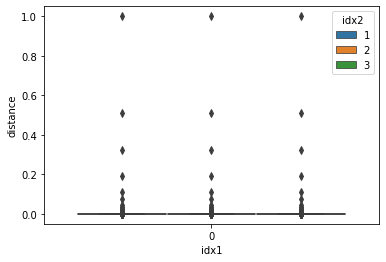

1 0
1 2
1 3


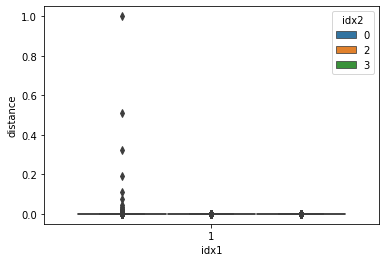

2 0
2 1
2 3


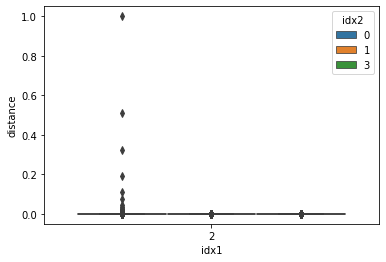

3 0
3 1
3 2


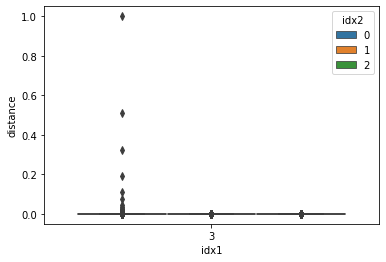

In [27]:
# given the same image, how different are the messages given by different senders
def euler_distance(a,b):
    # euler distance
    s = (a.loc[:,a.columns.str.contains('dim')].reset_index() - b.loc[:,b.columns.str.contains('dim')].reset_index())**2
    return s.sum(axis=1)**0.5

def cosine_distance(a,b):
    # cosine distance
    cos_dis = []
    a_dim = a.loc[:,a.columns.str.contains('dim')].reset_index()
    b_dim = b.loc[:,b.columns.str.contains('dim')].reset_index()
    cos_dis = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(a_dim.values), torch.Tensor(b_dim.values))
    return cos_dis


# display distances
for i,df_inter in enumerate(df_inters):
    for idx1 in range(4): # TODO : change to all available different senders
        df_distances = pd.DataFrame(columns=["distance","idx1","idx2"])
        for idx2 in range(4): # TODO : change to all available different senders
            a = df_inter[df_inter.sender_idx == idx1]
            b = df_inter[df_inter.sender_idx == idx2]
            if idx1 != idx2 and not (len(a) == 0 or  len(b) == 0):
                print(idx1,idx2)
                _dist=cosine_distance(a,b)
                _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":idx1, "idx2":idx2})
                df_distances = pd.concat([df_distances,_new_df_dist])
        if(len(df_distances.distance)!=0):
            sns.boxplot(y=df_distances.distance,x=df_distances.idx1, hue=df_distances.idx2)
            # plt.ylim(0, 2e-7) # TODO : deal with the scales
            plt.show()

## CLustering

In [55]:
# clustering
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

In [43]:
n_points_per_cluster = 250

X = df_inter.loc[:,df_inter.columns.str.contains('dim')].reset_index().to_numpy()

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)
# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)

labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


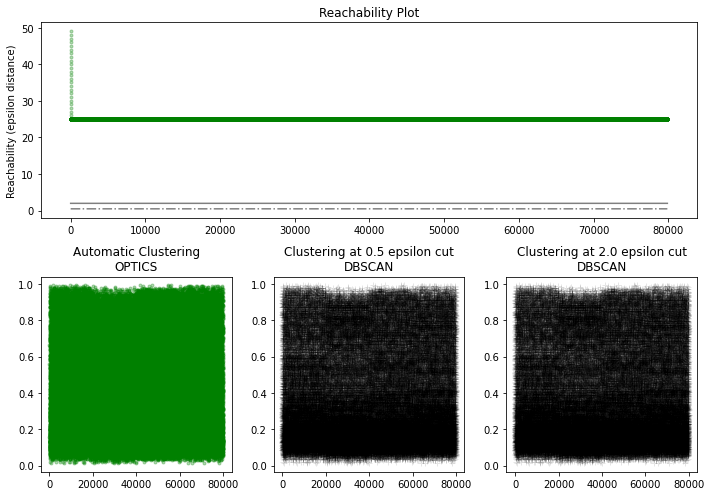

In [46]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [56]:
clust2 = KMeans()
clust.fit(X)
labels = clust.labels_[clust.ordering_]


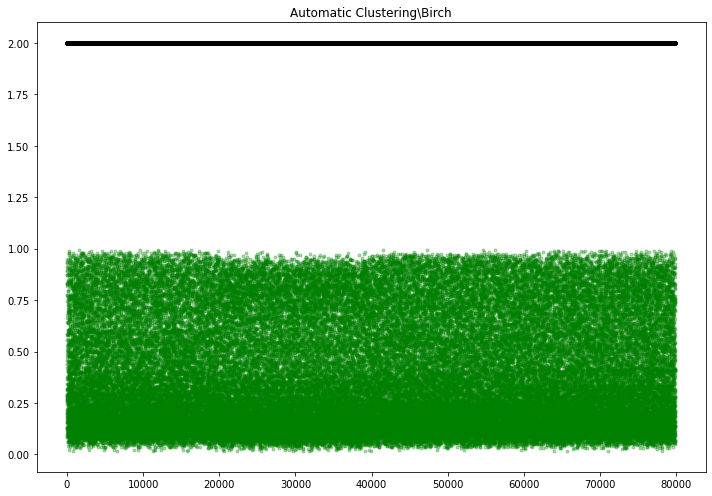

In [57]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
ax.plot(space, np.full_like(space, 2.0, dtype=float), "k.", alpha=0.3)
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\Birch")
plt.tight_layout()
plt.show()

## perturbations along dimensions

In [ ]:
# simple one_dimensional perturbations
# load a receiver
# take a message, increasingly perturbate a dimension, and send it
# look at the resulting receiver choice

In [ ]:
# perturbation accross multiple dimensions using PCA

## Begining of a PCA analysis
lets make an n component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

c:\Users\u203445\Miniconda3\envs\quiche\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\u203445\Miniconda3\envs\quiche\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\u203445\Miniconda3\envs\quiche\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

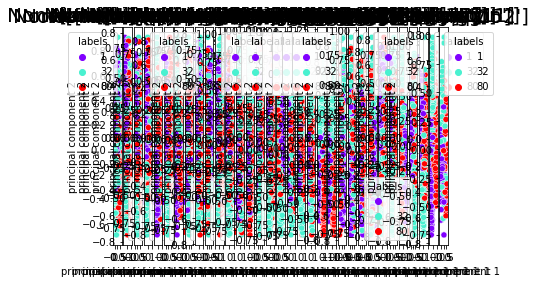

In [ ]:
## Parameter Selection
# select which senders and which pretraining class labels to visualise 
_chosen_sender_index = [0] # _chosen_sender_index = [0,1,2,3]
_chosen_labels = [1, 32, 80] # _chosen_labels = [i for i in range(100)]
# PCA parameters
n_components=10
# PCA dimensions to show on graph
prin_comp_A = 1
prin_comp_B = 2


df_pcas = []
fig, axes = plt.subplots(1,len(df_inters)) 
# lets get those sender specific PCAs
for i,df_inter in enumerate(df_inters):
    # taking only the interactions that have the matching indexes for the chosen sender and the class labels
    selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)] 

    # PCA
    pca = PCA(n_components)
    x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
    principalComponents = pca.fit_transform(x)
    df_pca = pd.DataFrame(data = principalComponents
                , columns = [f'principal component {i+1}' for i in range(n_components)])
    ## If we were to reuse those dimensions, this is what they look like : 
    # print(df_pca[['principal component 1','principal component 2']].sample(3))

    # plotting PCA
    sns.scatterplot(df_pca[f'principal component {prin_comp_A}'],
        df_pca[f'principal component {prin_comp_B}'], 
        hue = selectedsender_interactions.set_index(df_pca.index).labels,
        ax=axes[i],
        palette='rainbow',
    ).set_title(interaction_files[i], fontsize = 20),
    
    # ax.grid()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [ ]:
melted_dfs = []
for df_inter in df_inters:
    # Setting each dimension column as a categoric variable (called dim) of the same type (message value)
    _melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
    _melted_df.dim.replace([f"dim_{n}" for n in range(16)],[n for n in range(16)], inplace=True)
    melted_dfs.append(_melted_df)
print(melted_dfs[0].sample(3)) # have a look here if needed 

        sender_idx  loss_idx  recv_idx  labels  receiver_output  batch_number  \
74020            0         0         0      50               36         29028   
299126           0         0         0      70               54         29174   
160489           0         0         0      22               41         25513   

        dim  message_value  
74020     1       0.391322  
299126    6       0.313351  
160489    3       0.601442  


### Message Distribution

C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3521233354.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders


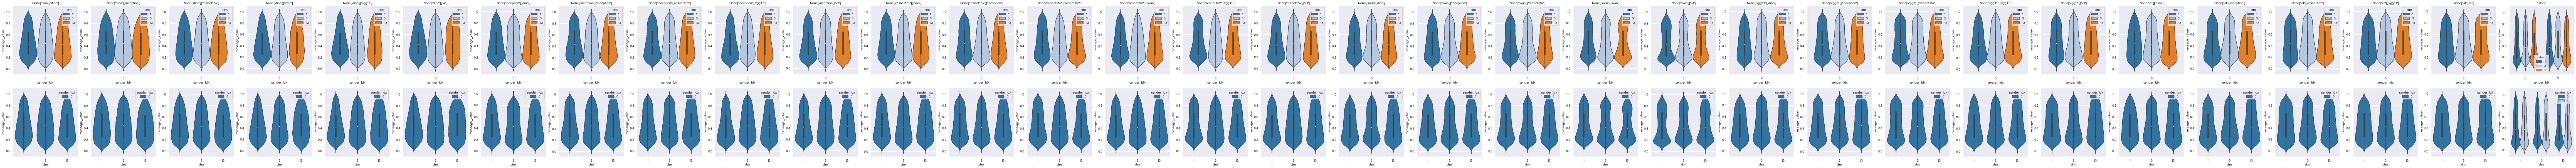

In [ ]:

## Parameter Selection
# select which senders and which dimension to visualise 
_chosen_sender_index = [0,3]   # _chosen_sender_index = [0,1,2,3]
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]

sns.set(rc={'figure.figsize':(5*len(melted_dfs),10)})
fig, axes = plt.subplots(2,len(melted_dfs)) 

# extract and plot
for i,melted_df in enumerate(melted_dfs):
    melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders
    sns.violinplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0,i]).set_title(interaction_files[i])
    sns.violinplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1,i])
    

# WIP : maybe add some statistical testing
# the way the violins look allow us to know where to set the saturation point were we to discretise

A quick look at the data distribution for messages in each dimension

Now we check if data distribution is modified by the class of the represented image (which it should if it wants to discriminate images)

C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3036899652.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.dim.isin(_chosen_dimensions)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3036899652.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.dim.isin(_chosen_dimensions)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_24104\3036899652.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = _df[melted_df.sender_idx.isin(_chosen_

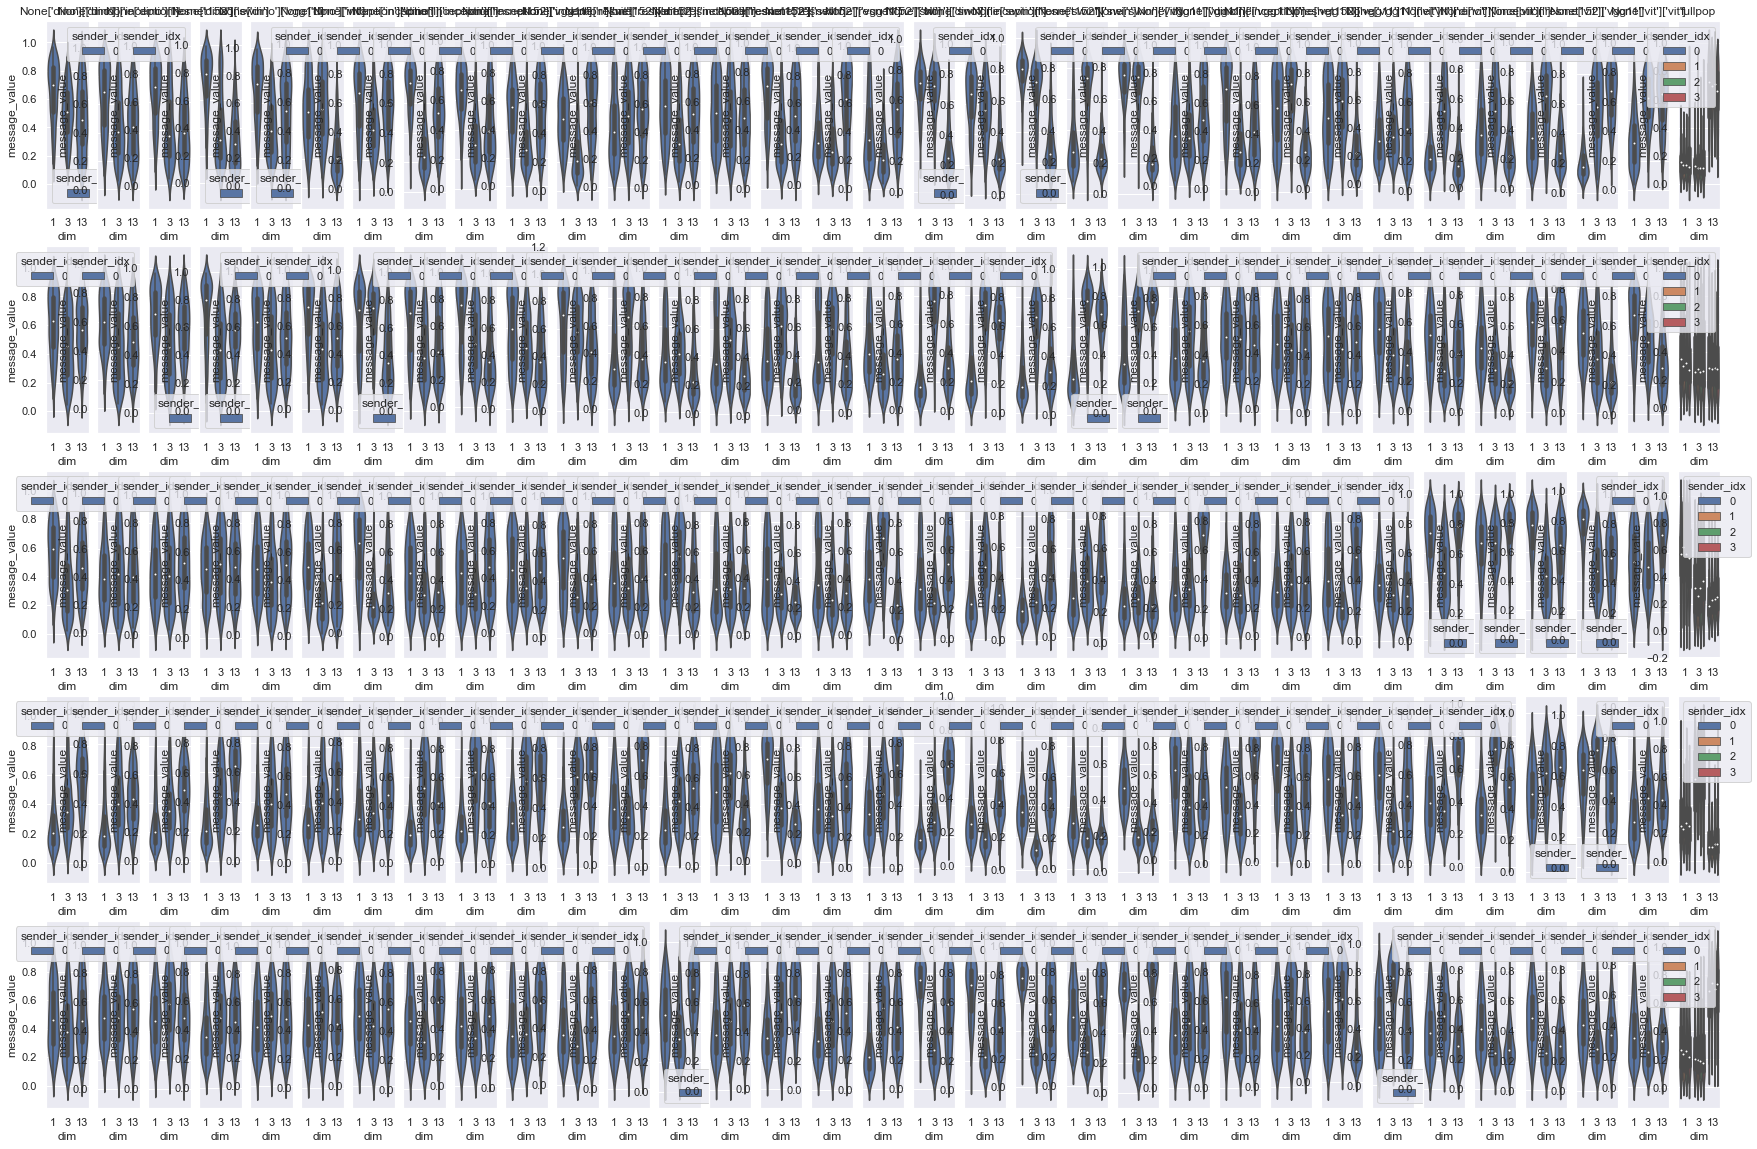

In [ ]:
## Parameter Selection
# select which senders and which classes to visualise 
_chosen_sender_idxs = [0,1,2,3]
_chosen_labels = torch.randint(0,100,[5]) # three random labels
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]


sns.set(rc={'figure.figsize':(10*len(_chosen_dimensions),4*len(_chosen_labels))})
fig, axes = plt.subplots(len(_chosen_labels),len(melted_dfs)) 

for i,melted_df in enumerate(melted_dfs):
    for j, label in enumerate(_chosen_labels):
        _df = melted_df[melted_df.labels==label.item()]
        _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
        _df = _df[melted_df.dim.isin(_chosen_dimensions)]
        if len(_df) != 0:
            sns.violinplot(x=_df.dim, y=_df.message_value, hue=_df.sender_idx, ax=axes[j,i]).set_title(interaction_files[i] if j == 0 else None)

# We can see variations in dimensional distribution depending on the pre-training classes. Each sender seems to encode it in a similar manner ! 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)
# vit, the agent with the most different representation, is in orange (sender_idx = 1). We can see it is always using slightly different communication distributions
# vgg (blue, idx = 0) seems to be the worst tricked by data_augmentation

### Dimension correlation

In [ ]:
# new imports, can't escape numpy
import numpy as np

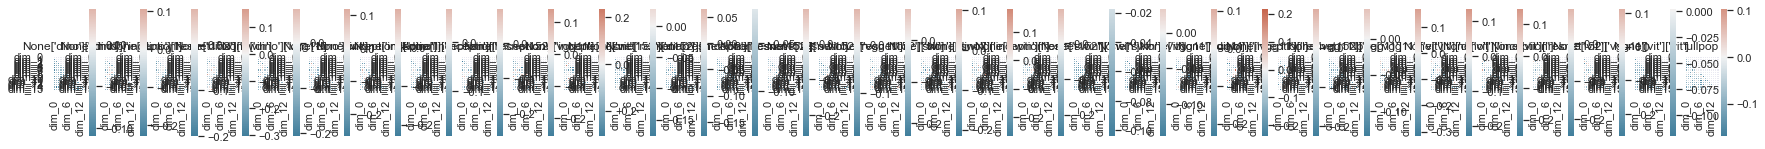

In [ ]:
# Ok. Correlation between dimensions now. Are any dimensions unnecessary ?
fig, axes = plt.subplots(1,len(df_inters)) 
for i,df_inter in enumerate(df_inters):
    # Compute the correlation matrix
    # (just on the dims, not on the rest of the information in interactions)
    corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=axes[i]).set_title(interaction_files[i])

# looks quite independant no ? with that in mind they'd all be necessary.

lets add :
* Independance of dims test
* entropy of pop languages vs one on one languages
* 